In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/EVA5/Week12/")

In [3]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-g9qu7xw3
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-g9qu7xw3
     |████████████████████████████████| 952kB 7.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=70462 sha256=51ede44385ad08e10d5a2ce1a06ac5be29621b796ef0b7aed4a24498b47198e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-1_cz711y/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
!pip install torch-lr-finder

In [5]:
!pip install torchsummary

## Importing Standard, Third-party and User-defined Libraries

In [6]:
%matplotlib inline
from utils.CyclicLearningRate import CyclicLR
import time
import torch
from torchsummary import summary
from torchvision.utils import make_grid, save_image
import torch.nn as nn
import torch.optim as optim

from configs import basic_config

from data.base_data_utils import get_data_loaders
from data.base_data_utils import get_imagenet_data_loaders
from data.base_data_utils import sample_data
from data.base_data_utils import show_train_data
from data.data_transforms.base_data_transforms import UnNormalize
from data.tiny_imagenet import TinyImageNetDataSet

from utils.misc_utils import get_device_type, current_config
from utils.visualization_utils import plot_multigraph, plot_misclassified_images, plot_LR_graph, visualize_clr
from utils import logger_utils

from models.networks import resnet
from models.model_builder import build_model
from models.gradcam.utils import visualize_cam
from models.gradcam.gradcam import GradCAM
from models.gradcam.gen_gradcam import generate_grad_cam_grid,generate_missclassified_gradcam_grid,upgraded_missclassified_gradcam_grid
from models.learning_rates.lr_range_test import LRRangeFinder

from orchestrators.base_orchestrator import start_training
from orchestrators.base_orchestrator import display_classwise_accuracy

## Configuration for the project

In [7]:
current_config()

EPOCHS - 50
OrderedDict - <class 'collections.OrderedDict'>
SEED - 1
agumentation_package - Albumentation
cuda - True
data - {'img_augs': OrderedDict([('PadIfNeeded', {'min_height': 70, 'min_width': 70, 'border_mode': 0, 'value': (0.4914, 0.4822, 0.4465), 'p': 1.0}), ('oneof_crop', {'randomcrop': {'height': 64, 'width': 64, 'p': 0.9}, 'centercrop': {'height': 64, 'width': 64, 'p': 0.1}, 'p': 1.0}), ('fliplr', {'p': 0.7}), ('cutout', {'num_holes': 1, 'max_h_size': 32, 'max_w_size': 32, 'fill_value': (0.4914, 0.4822, 0.4465), 'always_apply': False, 'p': 0.6})]), 'normalize_paras': [(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201)], 'dataloader_args': {'shuffle': True, 'batch_size': 128, 'num_workers': 16, 'pin_memory': True}, 'data_kind': {'dataset_type': 'open_datasets', 'dataset_name': 'tiny_imagenet', 'datasets_location': 'data/datasets'}}
l1_lambda - 0.0
logger_config - {'log_filename': 'logs/Session11_assignment', 'level': 20, 'format': '%(asctime)s %(levelname)-8s [%(filename)s:%(

In [8]:
logger = logger_utils.get_logger(__name__)

## Creating Train and Test Data Loaders

In [9]:
start_time = time.time()
train_loader, test_loader, classes = get_imagenet_data_loaders(dataset_name='tiny_imagenet',train_split=70)
print("--- %s seconds ---" % (time.time() - start_time))


**** Started Loading TinyImageNet data ****




Dataset length:  110000
Trainset length:  77000
Testset length:  33000
CUDA Available? True

**** Ended Loading TinyImageNet data ****

--- 1690.320987701416 seconds ---


## Peek at Sample Data

In [10]:
print(len(train_loader))

602


In [11]:
print(len(test_loader))

258


## Creating Model

## Network Summary

In [12]:
def print_summary(network,title):
  print(title)
  summary(network,input_size=(3,64,64))

In [13]:
device = get_device_type()
model = resnet.ResNet18(num_classes=200).to(device)
print_summary(model,'Network summary')

Network summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14   

/content/drive/My Drive/EVA5/Week12/models/networks/resnet.py:104: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## Find Max lr

In [14]:
def lr_range_test(model,start_lr, end_lr, step_mode, epochs, sgd_lr=5.34E-02, sgd_momentum=0.9):
  print(f'\n\n***** Started LR Test with step_mode={step_mode}, start_lr={start_lr}, end_lr={end_lr} *****\n\n')
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)
  lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
  lr_finder.range_test(train_loader, val_loader=test_loader, start_lr=start_lr, end_lr=end_lr,
                      epochs=epochs, step_mode=step_mode)
  lr_finder.plot(metric='acc', skip_start=0, skip_end=0)
  lr_finder.reset()
  best_acc = lr_finder.best_acc
  best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
  print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))
  print(f'\n\n***** Ended LR Test with step_mode={step_mode}, start_lr={start_lr}, end_lr={end_lr} *****\n\n')

In [15]:
linear_lr_pairs = [(1E-4, 0.5),]  ## Add pairs for lr range test in linear mode
exp_lr_pairs = [(1E-7,1E-1),] ## Add pairs for lr range test in exponential mode

In [16]:
## Linear Step Mode
#for start_lr, end_lr in linear_lr_pairs:
#  #model = get_model()
#  lr_range_test(model, start_lr, end_lr, 'linear', 50, sgd_lr=5.34E-02, sgd_momentum=0.9)  

## Preparing for Training

In [17]:
EPOCHS = basic_config.EPOCHS
device = get_device_type()
results = {}

models_dict = {'resnet': {'model': model}
          }

##Start Training

In [18]:
results = start_training(EPOCHS, device, train_loader, test_loader, **models_dict)

  0%|          | 0/602 [00:00<?, ?it/s]


**** Started training ****


Model: resnet

0 0
Optimizer paras: optimizer=sgd, lr=0.0534,momentum=0.9, weight_decay=0.0
LR Scheduler paras: {'max_lr': 0.10004247448979592, 'epochs': 50, 'pct_start': 0.3, 'steps_per_epoch': 602, 'cycle_momentum': False, 'div_factor': 10, 'final_div_factor': 1, 'anneal_strategy': 'linear', 'name': 'OneCycleLR'}
[EPOCH:1]

Current LR: 0.010004247448979592



/content/drive/My Drive/EVA5/Week12/models/networks/resnet.py:104: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Epoch=1 Iteration=602 Loss=3.8238232135772705 Batch_id=601 Current_train_batch_accuracy=7.49: 100%|██████████| 602/602 [07:38<00:00,  1.31it/s]



Train set: Average loss: 4.2012, Accuracy: 8065/77000 (10.47%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 4.1838, Accuracy: 3665/33000 (11.11%)

best_test_accuracy 11.106060606060606
[EPOCH:2]

Current LR: 0.016007460726039226



Epoch=2 Iteration=1204 Loss=3.457369804382324 Batch_id=601 Current_train_batch_accuracy=16.23: 100%|██████████| 602/602 [07:38<00:00,  1.31it/s]



Train set: Average loss: 3.8424, Accuracy: 11966/77000 (15.54%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.8236, Accuracy: 5426/33000 (16.44%)

best_test_accuracy 16.44242424242424
[EPOCH:3]

Current LR: 0.02201067400309886



Epoch=3 Iteration=1806 Loss=3.447713851928711 Batch_id=601 Current_train_batch_accuracy=22.39: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 3.6278, Accuracy: 15203/77000 (19.74%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.6135, Accuracy: 6866/33000 (20.81%)

best_test_accuracy 20.806060606060605
[EPOCH:4]

Current LR: 0.028013887280158488



Epoch=4 Iteration=2408 Loss=2.92557954788208 Batch_id=601 Current_train_batch_accuracy=27.52: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 3.1689, Accuracy: 20423/77000 (26.52%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.2459, Accuracy: 8588/33000 (26.02%)

best_test_accuracy 26.024242424242424
[EPOCH:5]

Current LR: 0.03401710055721813



Epoch=5 Iteration=3010 Loss=2.83223819732666 Batch_id=601 Current_train_batch_accuracy=31.93: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 3.0695, Accuracy: 22301/77000 (28.96%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.1412, Accuracy: 9656/33000 (29.26%)

best_test_accuracy 29.26060606060606
[EPOCH:6]

Current LR: 0.04002031383427776



Epoch=6 Iteration=3612 Loss=2.7464277744293213 Batch_id=601 Current_train_batch_accuracy=35.50: 100%|██████████| 602/602 [07:34<00:00,  1.32it/s]



Train set: Average loss: 2.7151, Accuracy: 27129/77000 (35.23%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8733, Accuracy: 11236/33000 (34.05%)

best_test_accuracy 34.04848484848485
[EPOCH:7]

Current LR: 0.046023527111337385



Epoch=7 Iteration=4214 Loss=2.1916074752807617 Batch_id=601 Current_train_batch_accuracy=38.91: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 2.6274, Accuracy: 28255/77000 (36.69%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8347, Accuracy: 11351/33000 (34.40%)

best_test_accuracy 34.3969696969697
[EPOCH:8]

Current LR: 0.05202674038839702



Epoch=8 Iteration=4816 Loss=2.1723811626434326 Batch_id=601 Current_train_batch_accuracy=41.86: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 2.4241, Accuracy: 31488/77000 (40.89%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6648, Accuracy: 12451/33000 (37.73%)

best_test_accuracy 37.73030303030303
[EPOCH:9]

Current LR: 0.05802995366545666



Epoch=9 Iteration=5418 Loss=2.2611584663391113 Batch_id=601 Current_train_batch_accuracy=44.45: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 2.3988, Accuracy: 31910/77000 (41.44%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6300, Accuracy: 12661/33000 (38.37%)

best_test_accuracy 38.36666666666667
[EPOCH:10]

Current LR: 0.06403316694251629



Epoch=10 Iteration=6020 Loss=2.1814393997192383 Batch_id=601 Current_train_batch_accuracy=46.90: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 2.1484, Accuracy: 35776/77000 (46.46%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4751, Accuracy: 13969/33000 (42.33%)

best_test_accuracy 42.33030303030303
[EPOCH:11]

Current LR: 0.07003638021957592



Epoch=11 Iteration=6622 Loss=2.0227458477020264 Batch_id=601 Current_train_batch_accuracy=49.42: 100%|██████████| 602/602 [07:34<00:00,  1.32it/s]



Train set: Average loss: 2.0513, Accuracy: 37292/77000 (48.43%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4198, Accuracy: 14418/33000 (43.69%)

best_test_accuracy 43.69090909090909
[EPOCH:12]

Current LR: 0.07603959349663557



Epoch=12 Iteration=7224 Loss=1.8022948503494263 Batch_id=601 Current_train_batch_accuracy=51.52: 100%|██████████| 602/602 [07:34<00:00,  1.32it/s]



Train set: Average loss: 1.9388, Accuracy: 39236/77000 (50.96%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3927, Accuracy: 15031/33000 (45.55%)

best_test_accuracy 45.54848484848485
[EPOCH:13]

Current LR: 0.08204280677369519



Epoch=13 Iteration=7826 Loss=2.0307841300964355 Batch_id=601 Current_train_batch_accuracy=53.80: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 1.7874, Accuracy: 41807/77000 (54.29%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2821, Accuracy: 15394/33000 (46.65%)

best_test_accuracy 46.64848484848485
[EPOCH:14]

Current LR: 0.08804602005075483



Epoch=14 Iteration=8428 Loss=2.011209487915039 Batch_id=601 Current_train_batch_accuracy=55.93: 100%|██████████| 602/602 [07:34<00:00,  1.33it/s]



Train set: Average loss: 1.7439, Accuracy: 42284/77000 (54.91%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3264, Accuracy: 15347/33000 (46.51%)

best_test_accuracy 46.64848484848485
[EPOCH:15]

Current LR: 0.09404923332781445



Epoch=15 Iteration=9030 Loss=1.5783883333206177 Batch_id=601 Current_train_batch_accuracy=58.06: 100%|██████████| 602/602 [07:37<00:00,  1.31it/s]



Train set: Average loss: 1.5834, Accuracy: 45090/77000 (58.56%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2228, Accuracy: 15788/33000 (47.84%)

best_test_accuracy 47.842424242424244
[EPOCH:16]

Current LR: 0.100038201199476



Epoch=16 Iteration=9632 Loss=1.2745639085769653 Batch_id=601 Current_train_batch_accuracy=60.35: 100%|██████████| 602/602 [07:39<00:00,  1.31it/s]



Train set: Average loss: 1.4294, Accuracy: 47920/77000 (62.23%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2131, Accuracy: 16407/33000 (49.72%)

best_test_accuracy 49.71818181818182
[EPOCH:17]

Current LR: 0.09746568042688124



Epoch=17 Iteration=10234 Loss=1.9720685482025146 Batch_id=601 Current_train_batch_accuracy=63.23: 100%|██████████| 602/602 [07:41<00:00,  1.31it/s]



Train set: Average loss: 1.3085, Accuracy: 49927/77000 (64.84%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2583, Accuracy: 16437/33000 (49.81%)

best_test_accuracy 49.80909090909091
[EPOCH:18]

Current LR: 0.09489315965428649



Epoch=18 Iteration=10836 Loss=1.5523462295532227 Batch_id=601 Current_train_batch_accuracy=65.76: 100%|██████████| 602/602 [07:38<00:00,  1.31it/s]



Train set: Average loss: 1.1597, Accuracy: 52763/77000 (68.52%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1690, Accuracy: 17037/33000 (51.63%)

best_test_accuracy 51.627272727272725
[EPOCH:19]

Current LR: 0.09232063888169174



Epoch=19 Iteration=11438 Loss=1.3141372203826904 Batch_id=601 Current_train_batch_accuracy=68.41: 100%|██████████| 602/602 [07:38<00:00,  1.31it/s]



Train set: Average loss: 1.1163, Accuracy: 53342/77000 (69.28%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2940, Accuracy: 16718/33000 (50.66%)

best_test_accuracy 51.627272727272725
[EPOCH:20]

Current LR: 0.08974811810909698



Epoch=20 Iteration=12040 Loss=1.2405421733856201 Batch_id=601 Current_train_batch_accuracy=70.76: 100%|██████████| 602/602 [07:38<00:00,  1.31it/s]



Train set: Average loss: 0.9569, Accuracy: 56454/77000 (73.32%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2541, Accuracy: 17186/33000 (52.08%)

best_test_accuracy 52.07878787878788
[EPOCH:21]

Current LR: 0.08717559733650224



Epoch=21 Iteration=12642 Loss=0.9514836072921753 Batch_id=601 Current_train_batch_accuracy=73.32: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.9218, Accuracy: 57086/77000 (74.14%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3598, Accuracy: 17076/33000 (51.75%)

best_test_accuracy 52.07878787878788
[EPOCH:22]

Current LR: 0.08460307656390748



Epoch=22 Iteration=13244 Loss=0.8705467581748962 Batch_id=601 Current_train_batch_accuracy=74.99: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.7993, Accuracy: 59510/77000 (77.29%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3231, Accuracy: 17366/33000 (52.62%)

best_test_accuracy 52.624242424242425
[EPOCH:23]

Current LR: 0.08203055579131273



Epoch=23 Iteration=13846 Loss=0.8388938903808594 Batch_id=601 Current_train_batch_accuracy=77.39: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.6969, Accuracy: 61693/77000 (80.12%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3444, Accuracy: 17478/33000 (52.96%)

best_test_accuracy 52.96363636363636
[EPOCH:24]

Current LR: 0.07945803501871798



Epoch=24 Iteration=14448 Loss=0.7090127468109131 Batch_id=601 Current_train_batch_accuracy=79.60: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.7181, Accuracy: 61176/77000 (79.45%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4960, Accuracy: 17094/33000 (51.80%)

best_test_accuracy 52.96363636363636
[EPOCH:25]

Current LR: 0.07688551424612322



Epoch=25 Iteration=15050 Loss=0.7555358409881592 Batch_id=601 Current_train_batch_accuracy=81.22: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.6074, Accuracy: 63464/77000 (82.42%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4900, Accuracy: 17405/33000 (52.74%)

best_test_accuracy 52.96363636363636
[EPOCH:26]

Current LR: 0.07431299347352847



Epoch=26 Iteration=15652 Loss=0.7190682888031006 Batch_id=601 Current_train_batch_accuracy=82.96: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.5049, Accuracy: 65731/77000 (85.36%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4357, Accuracy: 17650/33000 (53.48%)

best_test_accuracy 53.484848484848484
[EPOCH:27]

Current LR: 0.07174047270093373



Epoch=27 Iteration=16254 Loss=0.5983015298843384 Batch_id=601 Current_train_batch_accuracy=84.55: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.4786, Accuracy: 66194/77000 (85.97%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5551, Accuracy: 17803/33000 (53.95%)

best_test_accuracy 53.948484848484846
[EPOCH:28]

Current LR: 0.06916795192833897



Epoch=28 Iteration=16856 Loss=0.6455283761024475 Batch_id=601 Current_train_batch_accuracy=86.15: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.4274, Accuracy: 67303/77000 (87.41%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6377, Accuracy: 17644/33000 (53.47%)

best_test_accuracy 53.948484848484846
[EPOCH:29]

Current LR: 0.06659543115574422



Epoch=29 Iteration=17458 Loss=0.4026840329170227 Batch_id=601 Current_train_batch_accuracy=87.56: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.3812, Accuracy: 68514/77000 (88.98%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6190, Accuracy: 17782/33000 (53.88%)

best_test_accuracy 53.948484848484846
[EPOCH:30]

Current LR: 0.06402291038314947



Epoch=30 Iteration=18060 Loss=0.4840792119503021 Batch_id=601 Current_train_batch_accuracy=88.23: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.3287, Accuracy: 69511/77000 (90.27%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6718, Accuracy: 18045/33000 (54.68%)

best_test_accuracy 54.68181818181818
[EPOCH:31]

Current LR: 0.06145038961055471



Epoch=31 Iteration=18662 Loss=0.45634937286376953 Batch_id=601 Current_train_batch_accuracy=89.79: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.2953, Accuracy: 70369/77000 (91.39%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6350, Accuracy: 18208/33000 (55.18%)

best_test_accuracy 55.17575757575757
[EPOCH:32]

Current LR: 0.05887786883795996



Epoch=32 Iteration=19264 Loss=0.4027668237686157 Batch_id=601 Current_train_batch_accuracy=90.70: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.2708, Accuracy: 70907/77000 (92.09%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7174, Accuracy: 18072/33000 (54.76%)

best_test_accuracy 55.17575757575757
[EPOCH:33]

Current LR: 0.056305348065365204



Epoch=33 Iteration=19866 Loss=0.45024430751800537 Batch_id=601 Current_train_batch_accuracy=91.35: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.2463, Accuracy: 71489/77000 (92.84%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.6742, Accuracy: 18229/33000 (55.24%)

best_test_accuracy 55.23939393939394
[EPOCH:34]

Current LR: 0.05373282729277046



Epoch=34 Iteration=20468 Loss=0.27465274930000305 Batch_id=601 Current_train_batch_accuracy=91.96: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.2214, Accuracy: 71979/77000 (93.48%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7914, Accuracy: 18278/33000 (55.39%)

best_test_accuracy 55.38787878787879
[EPOCH:35]

Current LR: 0.051160306520175704



Epoch=35 Iteration=21070 Loss=0.2816520929336548 Batch_id=601 Current_train_batch_accuracy=92.66: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1940, Accuracy: 72668/77000 (94.37%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7791, Accuracy: 18355/33000 (55.62%)

best_test_accuracy 55.621212121212125
[EPOCH:36]

Current LR: 0.04858778574758095



Epoch=36 Iteration=21672 Loss=0.26365557312965393 Batch_id=601 Current_train_batch_accuracy=93.32: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1816, Accuracy: 72972/77000 (94.77%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7765, Accuracy: 18309/33000 (55.48%)

best_test_accuracy 55.621212121212125
[EPOCH:37]

Current LR: 0.0460152649749862



Epoch=37 Iteration=22274 Loss=0.25032201409339905 Batch_id=601 Current_train_batch_accuracy=93.75: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1639, Accuracy: 73367/77000 (95.28%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8075, Accuracy: 18467/33000 (55.96%)

best_test_accuracy 55.96060606060606
[EPOCH:38]

Current LR: 0.043442744202391456



Epoch=38 Iteration=22876 Loss=0.22024790942668915 Batch_id=601 Current_train_batch_accuracy=94.63: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1572, Accuracy: 73498/77000 (95.45%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8168, Accuracy: 18449/33000 (55.91%)

best_test_accuracy 55.96060606060606
[EPOCH:39]

Current LR: 0.0408702234297967



Epoch=39 Iteration=23478 Loss=0.1326853185892105 Batch_id=601 Current_train_batch_accuracy=94.80: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1416, Accuracy: 73879/77000 (95.95%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8125, Accuracy: 18584/33000 (56.32%)

best_test_accuracy 56.31515151515151
[EPOCH:40]

Current LR: 0.03829770265720195



Epoch=40 Iteration=24080 Loss=0.4543503522872925 Batch_id=601 Current_train_batch_accuracy=95.26: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1248, Accuracy: 74267/77000 (96.45%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7814, Accuracy: 18623/33000 (56.43%)

best_test_accuracy 56.43333333333333
[EPOCH:41]

Current LR: 0.03572518188460719



Epoch=41 Iteration=24682 Loss=0.19828855991363525 Batch_id=601 Current_train_batch_accuracy=95.70: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1172, Accuracy: 74458/77000 (96.70%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7906, Accuracy: 18702/33000 (56.67%)

best_test_accuracy 56.67272727272727
[EPOCH:42]

Current LR: 0.03315266111201244



Epoch=42 Iteration=25284 Loss=0.28792494535446167 Batch_id=601 Current_train_batch_accuracy=96.11: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1109, Accuracy: 74529/77000 (96.79%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8018, Accuracy: 18650/33000 (56.52%)

best_test_accuracy 56.67272727272727
[EPOCH:43]

Current LR: 0.030580140339417694



Epoch=43 Iteration=25886 Loss=0.1357058733701706 Batch_id=601 Current_train_batch_accuracy=96.37: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.1002, Accuracy: 74846/77000 (97.20%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8052, Accuracy: 18764/33000 (56.86%)

best_test_accuracy 56.86060606060606
[EPOCH:44]

Current LR: 0.028007619566822933



Epoch=44 Iteration=26488 Loss=0.07544185221195221 Batch_id=601 Current_train_batch_accuracy=96.55: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.0923, Accuracy: 74972/77000 (97.37%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8165, Accuracy: 18780/33000 (56.91%)

best_test_accuracy 56.90909090909091
[EPOCH:45]

Current LR: 0.025435098794228186



Epoch=45 Iteration=27090 Loss=0.0747026577591896 Batch_id=601 Current_train_batch_accuracy=96.88: 100%|██████████| 602/602 [07:37<00:00,  1.32it/s]



Train set: Average loss: 0.0852, Accuracy: 75203/77000 (97.67%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8032, Accuracy: 18814/33000 (57.01%)

best_test_accuracy 57.012121212121215
[EPOCH:46]

Current LR: 0.022862578021633426



Epoch=46 Iteration=27692 Loss=0.03204501420259476 Batch_id=601 Current_train_batch_accuracy=97.03: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.0782, Accuracy: 75381/77000 (97.90%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7799, Accuracy: 18848/33000 (57.12%)

best_test_accuracy 57.11515151515152
[EPOCH:47]

Current LR: 0.02029005724903868



Epoch=47 Iteration=28294 Loss=0.12647490203380585 Batch_id=601 Current_train_batch_accuracy=97.34: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.0756, Accuracy: 75373/77000 (97.89%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7940, Accuracy: 18882/33000 (57.22%)

best_test_accuracy 57.21818181818182
[EPOCH:48]

Current LR: 0.017717536476443918



Epoch=48 Iteration=28896 Loss=0.10257384181022644 Batch_id=601 Current_train_batch_accuracy=97.46: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.0692, Accuracy: 75588/77000 (98.17%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7818, Accuracy: 18898/33000 (57.27%)

best_test_accuracy 57.266666666666666
[EPOCH:49]

Current LR: 0.015145015703849185



Epoch=49 Iteration=29498 Loss=0.03358389064669609 Batch_id=601 Current_train_batch_accuracy=97.68: 100%|██████████| 602/602 [07:35<00:00,  1.32it/s]



Train set: Average loss: 0.0662, Accuracy: 75604/77000 (98.19%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7883, Accuracy: 19004/33000 (57.59%)

best_test_accuracy 57.587878787878786
[EPOCH:50]

Current LR: 0.012572494931254424



Epoch=50 Iteration=30100 Loss=0.04181082546710968 Batch_id=601 Current_train_batch_accuracy=97.81: 100%|██████████| 602/602 [07:36<00:00,  1.32it/s]



Train set: Average loss: 0.0627, Accuracy: 75694/77000 (98.30%)


Test set: Average loss: 2.7787, Accuracy: 18997/33000 (57.57%)

best_test_accuracy 57.587878787878786

results : {'resnet': [[10.474025974025974, 15.54025974025974, 19.744155844155845, 26.523376623376624, 28.962337662337664, 35.23246753246753, 36.6948051948052, 40.89350649350649, 41.44155844155844, 46.46233766233766, 48.43116883116883, 50.955844155844154, 54.29480519480519, 54.91428571428571, 58.55844155844156, 62.23376623376623, 64.84025974025974, 68.52337662337662, 69.27532467532467, 73.31688311688312, 74.13766233766233, 77.28571428571429, 80.12077922077923, 79.44935064935065, 82.42077922077922, 85.36493506493507, 85.96623376623377, 87.4064935064935, 88.97922077922078, 90.27402597402597, 91.38831168831169, 92.08701298701298, 92.84285714285714, 93.47922077922078, 94.37402597402597, 94.76883116883117, 95.28181818181818, 95.45194805194805, 95.94675324675325, 96.45064935064936, 96.6987012987013, 96.7909090909091, 97.20259

In [19]:
torch.save(model, f'check_points/Session12_assignment_epochs_{EPOCHS}.h5')

In [20]:
lst_plottingJobs_acc = []
lst_plottingLegends_acc = []
lst_plotting_loss = []
lst_plottingLegends_loss = []
lst_plotting_lr = []
lst_plottingLegends_lr = []

for model_type in results:
  lst_plottingJobs_acc.append(results[model_type][0])
  lst_plottingJobs_acc.append(results[model_type][2])
  
  lst_plottingLegends_acc.append('Training accuracy')
  lst_plottingLegends_acc.append('Validation accuracy')

  lst_plotting_loss.append(results[model_type][1])
  lst_plotting_loss.append(results[model_type][3])

  lst_plottingLegends_loss.append('Training loss')
  lst_plottingLegends_loss.append('Validation loss')

  lst_plotting_lr.append(results[model_type][5])
  lst_plottingLegends_lr.append('Learning Rate')

## Plotting model evaluation results


**** Started Plotting multigraph ****



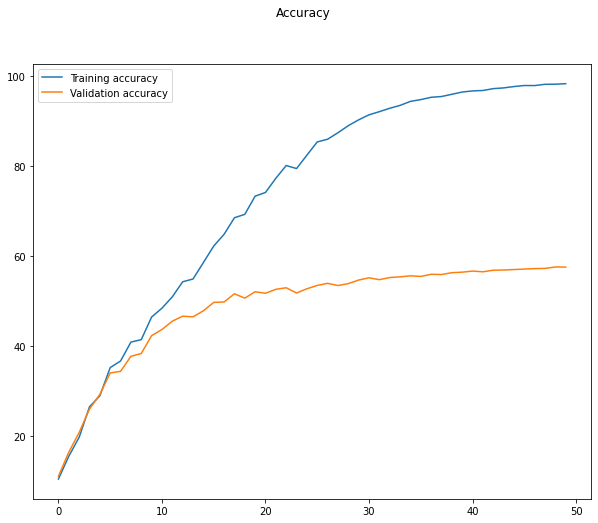


**** Ended Plotting multigraph ****



In [21]:
plot_multigraph(lst_plottingJobs_acc,lst_plottingLegends_acc,title="Accuracy")


**** Started Plotting multigraph ****



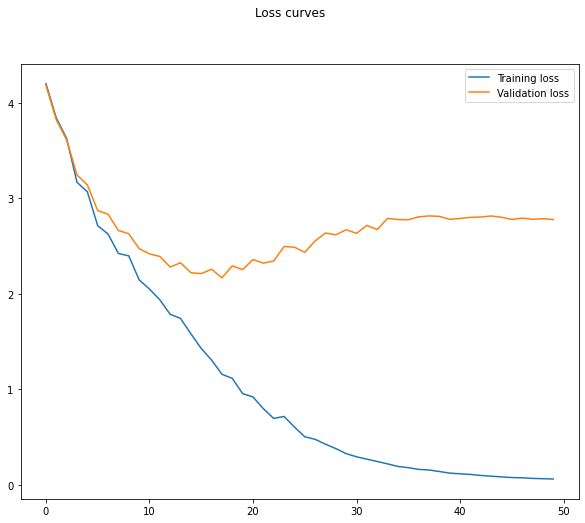


**** Ended Plotting multigraph ****



In [22]:
plot_multigraph(lst_plotting_loss,lst_plottingLegends_loss,title="Loss curves")

## Plotting Change in Learning rate during model training


**** Started Plotting multigraph ****



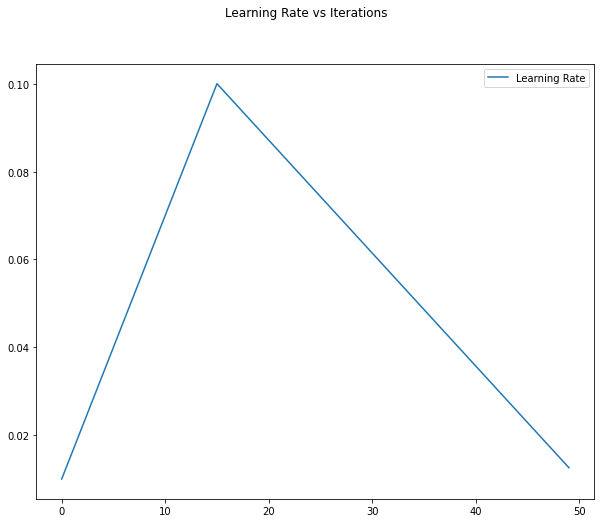


**** Ended Plotting multigraph ****



In [23]:
plot_multigraph(lst_plotting_lr,lst_plottingLegends_lr,title="Learning Rate vs Iterations")

## Plotting Loss curve at different learning rates during the model Training


**** Started Plotting Graph ****



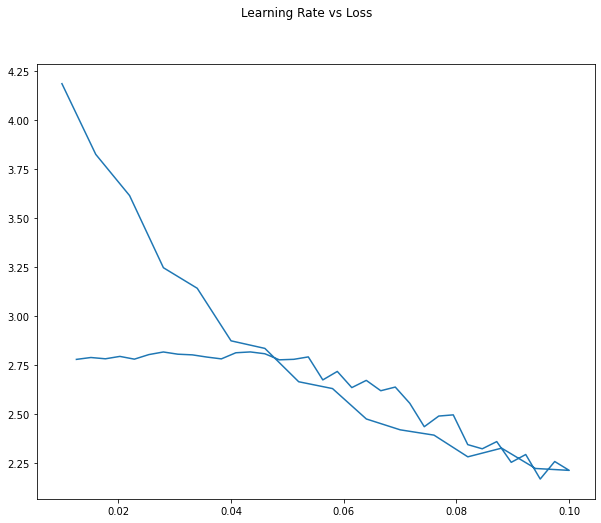


**** Ended Plotting multigraph ****



In [24]:
plot_LR_graph(results[model_type][3],results[model_type][5],'Learning Rate vs Loss')